## Introduction to LightGBM 

Source: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

Import the necessary libraries


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("Social_Network_Ads.csv")
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [3]:
target = data.Purchased
x = data.drop(columns=["Purchased","User ID"])
x = pd.get_dummies(x)
[x.columns]

[Index(['Age', 'EstimatedSalary', 'Gender_Female', 'Gender_Male'], dtype='object')]

## Initialization

In [4]:
import pandas as pd
dummy_df_age = pd.DataFrame({'age': ['0-20', '20-40', '40-60','60-80']})

func = lambda x: x.split('-')
dummy_df_age['start'], dummy_df_age['end'] = zip(* map(lambda x: x.split('-'),dummy_df_age['age']))
dummy_df_age.head()

,age,start,end
0,0-20,0,20
1,20-40,20,40
2,40-60,40,60
3,60-80,60,80


## Exploratory Data Analysis

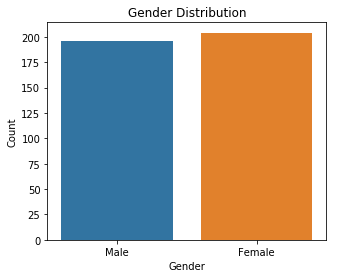

In [5]:
figure = plt.figure(figsize=(5,4))
sns.countplot(data.Gender)
plt.title('Gender Distribution')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

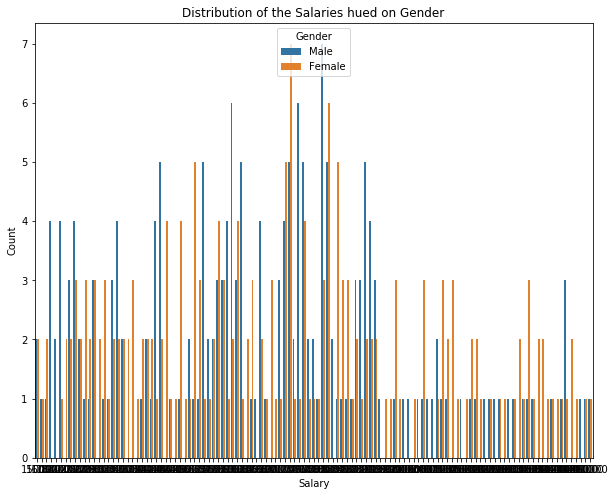

In [6]:
figure = plt.figure(figsize=(10,8))
sns.countplot(x.EstimatedSalary,hue = data.Gender)
plt.title('Distribution of the Salaries hued on Gender')
plt.ylabel('Count')
plt.xlabel('Salary')
plt.show()

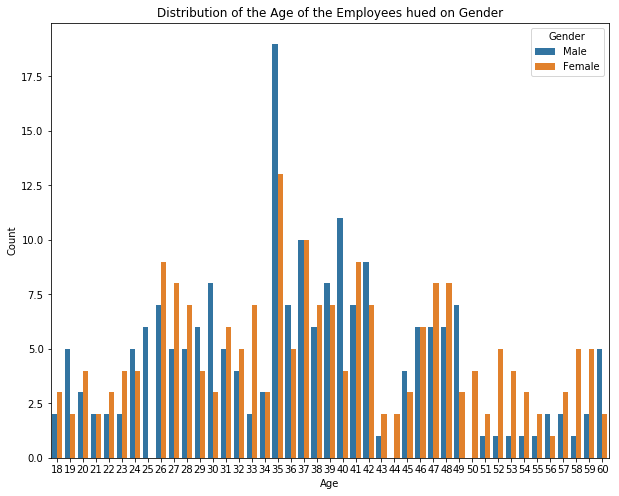

In [7]:
figure = plt.figure(figsize=(10,8))
sns.countplot(x.Age,hue = data.Gender)
plt.title('Distribution of the Age of the Employees hued on Gender')
plt.ylabel('Count')
plt.xlabel('Age')
plt.show()

## Splitting the Data into Train and Test Data

In [8]:
xtrain,xtest,ytrain,ytest = train_test_split(x,target,test_size= 0.25,random_state=12)
print("Sample     Shape")
print("x_train: ",xtrain.shape)
print("y_train: ",ytrain.shape)
print("x_test: ",xtest.shape)
print("y_test: ",ytest.shape)


Sample     Shape
x_train:  (300, 4)
y_train:  (300,)
x_test:  (100, 4)
y_test:  (100,)


### Use Standard Scaler to for feature Scaling

In [9]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# x = pd.DataFrame(x,columns=['Age', 'EstimatedSalary', 'Gender_Female', 'Gender_Male'])
# x.head()

### Implementation of LightGBM 

In [10]:
import lightgbm as lgb

# Convert the data to the format required by the model
d_train = lgb.Dataset(xtrain,label = ytrain)


# Setting up the parameters for the model 
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['max_depth'] = 10
params['min_data'] = 50
params['max_bin'] = 10


In [11]:
# Train the data `d_train` using the parameters over 5000 interations
clf = lgb.train(params, d_train,10000)


In [12]:
# Output of the model is in the form of probabilities

# Validate the data over the test set
y_pred =clf.predict(xtest)

# We use a threshold value to set the target value
for i in range(ytest.shape[0]):
    if y_pred[i]>=0.4:
        y_pred[i] = 1
    else:
        y_pred[i] = 0


# Evaluation of the model         
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(ytest,y_pred)
accuracy = accuracy_score(y_pred,ytest)
print("Confusion Matrix:",cm,sep = '\n\n')
print()
print("Accuracy of the model: ",accuracy)


Confusion Matrix:

[[50 11]
 [ 5 34]]

Accuracy of the model:  0.84


# Summarization of the LightGBM 

Following set of practices can be used to **improve your model efficiency.**

   * num_leaves: This is the main parameter to control the complexity of the tree model. Ideally, the value of num_leaves should be less than or equal to 2^(max_depth). Value more than this will result in overfitting.
   * min_data_in_leaf: Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
   * max_depth: You also can use max_depth to limit the tree depth explicitly.

##### For Faster Speed:

   * Use bagging by setting bagging_fraction and bagging_freq
   * Use feature sub-sampling by setting feature_fraction
   * Use small max_bin
   * Use save_binary to speed up data loading in future learning
   * Use parallel learning, refer to parallel learning guide.

#### For better accuracy:

   * Use large max_bin (may be slower)
   * Use small learning_rate with large num_iterations
   * Use large num_leaves(may cause over-fitting)
   * Use bigger training data
   * Try dart
   * Try to use categorical feature directly

#### To deal with over-fitting: 

 *  Use small max_bin
 *  Use small num_leaves
 *  Use min_data_in_leaf and min_sum_hessian_in_leaf
 *  Use bagging by set bagging_fraction and bagging_freq
 *  Use feature sub-sampling by set feature_fraction
 *  Use bigger training data
 *  Try lambda_l1, lambda_l2 and min_gain_to_split to regularization
 *  Try max_depth to avoid growing deep tree